In [1]:
import pandas as pd

In [2]:
pos_df = pd.read_csv("./datasets/pos_english_text.csv", encoding="latin")
neg_df = pd.read_csv("./datasets/neg_english_text.csv", encoding="latin")
raw_df = pd.concat([pos_df, neg_df])
raw_df

sentiment                                               text
0               4       I LOVE @Health4UandPets u guys r the best!! 
1               4  im meeting up with one of my besties tonight! ...
2               4  @DaRealSunisaKim Thanks for the Twitter add, S...
3               4  Being sick can be really cheap when it hurts t...
4               4    @LovesBrooklyn2 he has that effect on everyone 
...           ...                                                ...
799994          0  Sick  Spending my day laying in bed listening ...
799995          0                                    Gmail is down? 
799996          0                      rest in peace Farrah! So sad 
799997          0  @Eric_Urbane Sounds like a rival is flagging y...
799998          0  has to resit exams over summer...  wishes he w...

[1599999 rows x 2 columns]

In [3]:
lab_to_sentiment = {0: "Negative", 4: "Positive"}


def label_decoder(label):
    return lab_to_sentiment[label]


raw_df.sentiment = raw_df.sentiment.apply(lambda x: label_decoder(x))
raw_df

sentiment                                               text
0       Positive       I LOVE @Health4UandPets u guys r the best!! 
1       Positive  im meeting up with one of my besties tonight! ...
2       Positive  @DaRealSunisaKim Thanks for the Twitter add, S...
3       Positive  Being sick can be really cheap when it hurts t...
4       Positive    @LovesBrooklyn2 he has that effect on everyone 
...          ...                                                ...
799994  Negative  Sick  Spending my day laying in bed listening ...
799995  Negative                                    Gmail is down? 
799996  Negative                      rest in peace Farrah! So sad 
799997  Negative  @Eric_Urbane Sounds like a rival is flagging y...
799998  Negative  has to resit exams over summer...  wishes he w...

[1599999 rows x 2 columns]

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599999 entries, 0 to 799998
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  object
 1   text       1599999 non-null  object
dtypes: object(2)
memory usage: 36.6+ MB


In [5]:
raw_df.describe()

sentiment                       text
count    1599999                    1599999
unique         2                    1581465
top     Positive  isPlayer Has Died! Sorry 
freq      800000                        210

In [6]:
raw_df.drop_duplicates(inplace=True)
raw_df.describe().T

count   unique  \
sentiment  1583690        2   
text       1583690  1581465   

                                                         top    freq  
sentiment                                           Positive  793506  
text       @kezzawezz Yaba!  Enjoy your time doon there.....       2

In [7]:
raw_df.groupby(['sentiment']).size().reset_index(name='counts')

sentiment  counts
0  Negative  790184
1  Positive  793506

In [8]:
abbreviations_df = pd.read_csv("./datasets/abbreviations.csv")
apostrophe_df = pd.read_csv("./datasets/apostrophe.csv")
emoji_df = pd.read_csv("./datasets/emoji.csv")
emoticons_df = pd.read_csv("./datasets/emoticons.csv")

In [10]:
abbreviations_dict = dict(abbreviations_df.values)
apostrophe_dict = dict(apostrophe_df.values)
emoji_dict = dict(emoji_df.values)
emoticons_dict = dict(emoticons_df.values)

In [11]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary and word.lower() in text.split():
            text = text.replace(word, dictionary[word.lower()])
    return text

In [12]:
def translate(input_text):
    from googletrans import Translator
    translator = Translator()
    text = translator.translate(input_text).text
    return str(text)

In [13]:
def preProcessing(input_text, isSpellCheck=False, isTranslate=False):
    # Step A : Converting html entities i.e. (&lt; &gt; &amp;)
    import html
    text = html.unescape(input_text)
    # Step B : Removing "@user" from all the tweets
    import re
    text = re.sub("@[\w]*", "", text)
    # Step C : Remove http & https links
    text = re.sub("http://\S+|https://\S+", "", text)
    # Step D: Translation
    if isTranslate:
        text = translate(text)
    # Step E : Emoticon Lookup
    text = lookup_dict(text, emoticons_dict)
    # Step F : Emoji Lookup
    text = lookup_dict(text, emoji_dict)
    # Step G : Changing all the tweets into lowercase
    text = text.lower()
    # Step H : Apostrophe Lookup
    text = lookup_dict(text, apostrophe_dict)
    # Step I : Short Word Lookup
    text = lookup_dict(text, abbreviations_dict)
    # Step K : Replacing Punctuations with space
    text = re.sub(r"[^\w\s]", " ", text)
    # Step L : Replacing Special Characters & Numbers (integers) with space
    text = re.sub(r"[^a-zA-Z]", " ", text)
    # Step M : Spelling Correction - With TextBlob Library
    if isSpellCheck:
        from textblob import TextBlob
        text = str(TextBlob(text).correct())
    # Step N: Remove whitespace
    text = re.sub(r"\s+", " ", text)

    return text

In [14]:
from tqdm import tqdm
tqdm.pandas()

In [15]:
raw_df = raw_df.sample(1000)

In [16]:
raw_df['clear_text'] = raw_df['text'].progress_apply(lambda x: preProcessing(x))
raw_df.head()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1000/1000 [00:00<00:00, 8813.95it/s]


sentiment                                               text  \
410758  Positive             In school  english lit this morning!!!   
313826  Negative                       so hungry &amp; out of food    
278860  Positive  I'm now following Liz Taylor.... I hope that's...   
640371  Negative  ahhh sorrrryyyy for all the unanswered phone c...   
279130  Positive  @kathyireland I google my twit &amp; found mys...   

                                               clear_text  
410758                in school english lit this morning   
313826                             so hungry out of food   
278860  i m now following liz taylor i hope that is ok...  
640371  ahhh sorrrryyyy for all the unanswered phone c...  
279130   i google my twit found myslf on odd lists sai...

In [17]:
pd.set_option('display.max_colwidth', None)
raw_df[["text", "clear_text"]].sample(20)

text  \
682257                   Last breakfast  with my hubby.HeÃƒÂ‚Ã‚Â´s going on a business trip to Taiwan today, IÃƒÂ‚Ã‚Â´ll feel sooo lonely!    
225509                                                                     And then thebirthday ended badly with me alone In a bar    
654026                                                                                              @paperbyfmn I took your advice    
547295  @gaztrue you've gotta start somewhere to get where you're going. keep up the good work and keep fighting. i know you will!    
444902                                                                                                 hanging out with @summerglo    
234769                                                                                                  my fingers smell of garlic    
141829                                                     Finally attempting to go to bed with Azima while Ruhee is on the floor.    
723613   @jalapenosite that sounds tooo maaachhh!! all the sacrifices lol... just relax and observe, that is the best way to learn    
45317                                                                                       Madness with blogging drive. Why?! 3AM    
449273                                                                                                            Losing my voice.    
691600                                    @twizzle36 yes it's not right.  She was too young and I am sure had so much more to give    
35068                                                @stephenfry Im a wordsmith and a poet, enjoy me and make me millions!  please.   
158779                                       I am starting a new project in expanding my online beauty store Dream Hair Boutique!!    
94814                                                                                                   @steph_thtgirl15 Welcomes!    
322200                                                                                                         @jesikaaah i concur    
774431                                                            @michaeledge &quot;contraception in Africa.&quot; I'm in Bristol    
618597        @carty_yeah Get 100 followers a day using www.tweeteradder.com Once you add everyone you are on the train or pay vip    
695471                                                        tryin to mentally prepare myself to clean my room...n missing my car    
50681                                                                                         @leewaters @TracerBullet  TO CANADA!    
651261                                            @Haylz2329 4 stone wot u wana b skin n bones  not gud ur perfecto the way u r xxx   

                                                                                                                                                                    clear_text  
682257                                                                       last breakfast with my hubby he s going on a business trip to taiwan today i ll feel sooo lonely   
225509                                                                                                                and then thebirthday ended badly with me alone in a bar   
654026                                                                                                                                                     i took your advice   
547295                                                     you have got to start somewhere to get where you are going keep up the good work and keep fighting i know you will   
444902                                                                                                                                                       hanging out with   
234769                                                                                                                                             my fingers smell of garlic   
141829                                      

In [18]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize(clean_text):
    tokens = word_tokenize(clean_text)
    stop_words = set(stopwords.words("english"))
    negation_words = [
        "not",
        "never",
        "neither",
        "nor",
        "barely",
        "hardly",
        "scarcely",
        "seldom",
        "rarely",
        "no",
        "nothing",
        "none",
        "nobody",
        "nowhere",
    ]
    return [token for token in tokens if token in negation_words or token not in stop_words]

In [19]:
raw_df['tokens'] = raw_df['clear_text'].progress_apply(lambda x: tokenize(x))
raw_df.head()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1000/1000 [00:01<00:00, 701.12it/s]


sentiment  \
410758  Positive   
313826  Negative   
278860  Positive   
640371  Negative   
279130  Positive   

                                                                                                                                                  text  \
410758                                                                                                          In school  english lit this morning!!!   
313826                                                                                                                    so hungry &amp; out of food    
278860                                                                   I'm now following Liz Taylor.... I hope that's ok under my restraining order    
640371                                                     ahhh sorrrryyyy for all the unanswered phone calls/text!!! i left my phone at home all day    
279130  @kathyireland I google my twit &amp; found myslf on odd lists. 1 said I twit 2 muc @7 need to get a life. LOL. I'm a single mom. ALWAYS HOME!    

                                                                                                             clear_text  \
410758                                                                              in school english lit this morning    
313826                                                                                           so hungry out of food    
278860                                       i m now following liz taylor i hope that is ok under my restraining order    
640371                         ahhh sorrrryyyy for all the unanswered phone calls text i left my phone at home all day    
279130   i google my twit found myslf on odd lists said i twit muc need to get a life lol i m a single mom always home    

                                                                                                            tokens  
410758                                                                             [school, english, lit, morning]  
313826                                                                                              [hungry, food]  
278860                                                      [following, liz, taylor, hope, ok, restraining, order]  
640371                                  [ahhh, sorrrryyyy, unanswered, phone, calls, text, left, phone, home, day]  
279130  [google, twit, found, myslf, odd, lists, said, twit, muc, need, get, life, lol, single, mom, always, home]

In [20]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    import nltk
    from nltk.corpus import wordnet

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)

In [21]:
def Lemmatizer(tokens):
    # Importing library for lemmatizing
    from nltk.stem.wordnet import WordNetLemmatizer

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in tokens]

In [22]:
raw_df['lemmats'] = raw_df['tokens'].progress_apply(lambda x: Lemmatizer(x))
raw_df.head()

100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 1000/1000 [00:34<00:00, 29.36it/s]


sentiment  \
410758  Positive   
313826  Negative   
278860  Positive   
640371  Negative   
279130  Positive   

                                                                                                                                                  text  \
410758                                                                                                          In school  english lit this morning!!!   
313826                                                                                                                    so hungry &amp; out of food    
278860                                                                   I'm now following Liz Taylor.... I hope that's ok under my restraining order    
640371                                                     ahhh sorrrryyyy for all the unanswered phone calls/text!!! i left my phone at home all day    
279130  @kathyireland I google my twit &amp; found myslf on odd lists. 1 said I twit 2 muc @7 need to get a life. LOL. I'm a single mom. ALWAYS HOME!    

                                                                                                             clear_text  \
410758                                                                              in school english lit this morning    
313826                                                                                           so hungry out of food    
278860                                       i m now following liz taylor i hope that is ok under my restraining order    
640371                         ahhh sorrrryyyy for all the unanswered phone calls text i left my phone at home all day    
279130   i google my twit found myslf on odd lists said i twit muc need to get a life lol i m a single mom always home    

                                                                                                            tokens  \
410758                                                                             [school, english, lit, morning]   
313826                                                                                              [hungry, food]   
278860                                                      [following, liz, taylor, hope, ok, restraining, order]   
640371                                  [ahhh, sorrrryyyy, unanswered, phone, calls, text, left, phone, home, day]   
279130  [google, twit, found, myslf, odd, lists, said, twit, muc, need, get, life, lol, single, mom, always, home]   

                                                                                                         lemmats  
410758                                                                           [school, english, lit, morning]  
313826                                                                                            [hungry, food]  
278860                                                          [follow, liz, taylor, hope, ok, restrain, order]  
640371                                 [ahhh, sorrrryyyy, unanswered, phone, call, text, left, phone, home, day]  
279130  [google, twit, found, myslf, odd, list, say, twit, muc, need, get, life, lol, single, mom, always, home]

In [23]:
raw_df.sample(10)

sentiment  \
382077  Negative   
132713  Positive   
631067  Positive   
617885  Positive   
481219  Negative   
502204  Negative   
384885  Positive   
58624   Negative   
657463  Negative   
21857   Positive   

                                                                                                                                       text  \
382077  havin a beer-can sandwich then headin off for dover  all for a lil buffet and a moonbounce! no way in hell am i wearin a sumo suit!   
132713                                                                                                             lovin my new blackberry    
631067                                                                                         @shand0chit0 Hi Momma Frank!    Remember me?   
617885                                                                         @umahameed so lucky girl. Say hi to Big Ben for me pleaseee    
481219                                                                                                                     Stuck in class.    
502204                                                                                                  At the hospital with my baby  fever   
384885                                         Going to read 'The Boy in The Striped Pyjamas'  Junior Cert exams are starting on wednesday.   
58624                                                                                                       Shot himself in the foot  OUCH!   
657463                                                                                                       @Jasminexoxo Yeah i am sorry!    
21857                                                                         Have a couple hours to burn between jobs. . . Thinking beer.    

                                                                                                                                         clear_text  \
382077  havin a beer can sandwich then headin off for dover all for a lil buffet and a moonbounce no where are you in hell am i wearin a sumo suit    
132713                                                                                                                     lovin my new blackberry    
631067                                                                                                                  hi momma frank remember me    
617885                                                                                             so lucky girl say hi to big ben for me pleaseee    
481219                                                                                                                              stuck in class    
502204                                                                                                           at the hospital with my baby fever   
384885                                                    going to read the boy in the striped pyjamas junior cert exams are starting on wednesday    
58624                                                                                                                shot himself in the foot ouch    
657463                                                                                                                             yeah i am sorry    
21857                                                                                       have a couple hours to burn between jobs thinking beer    

                                                                                               tokens  \
382077  [havin, beer, sandwich, headin, dover, lil, buffet, moonbounce, no, hell, wearin, sumo, suit]   
132713                                                                       [lovin, new, blackberry]   
631067                                                                   [hi, momma, frank, remember]   
617885                                                     [lucky, girl, say, hi, big, ben, pleaseee]   
481219                   

## Model training

In [24]:
df = pd.read_csv("./datasets/tokens.csv")

In [25]:
df = df.sample(1000)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    df["lemmats"].apply(lambda x: "".join(x)),
    df["sentiment"],
    test_size=0.3,
    random_state=60,
    shuffle=True,
    stratify=df["sentiment"],
)
X_train

406937     ['love', 'heart', 'like', 'nd', 'rd', 'best', 'th', 'badly', 'write', 'bella', 'give', 'every', 'thing', 'stood']
278380                                                  ['law', 'enforcement', 'officer', 'allen', 'not', 'see', 'hmmmmmmm']
689725                                                           ['people', 'fui', 'see', 'ya', 'tomorrow', 'good', 'night']
902864                                           ['busy', 'sunday', 'ahead', 'problem', 'weather', 'isnt', 'ha', 'f', 'bad']
1015663                                    ['last', 'night', 'together', 'dad', 'play', 'air', 'guitar', 'hero', 'basement']
                                                                 ...                                                        
974188                                                      ['sick', 'friday', 'night', 'stay', 'home', 'tonighttt', 'lame']
758045                                                                                 ['possibly', 'go', 'chicago', 'july']


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_text = vectorizer.fit_transform(X_train)
tfidf_text

<700x2027 sparse matrix of type '<class 'numpy.float64'>'
	with 4967 stored elements in Compressed Sparse Row format>

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def model_result(clf, X_train, Y_train, X_test, Y_test):
    print(f"Clf: {clf}")
    model = Pipeline(
        [
            ("tfidf", TfidfVectorizer()),
            ("clf", clf)
        ]
    )
    model.fit(X_train, Y_train)
    test_predict = model.predict(X_test)

    train_accuracy = round(model.score(X_train, Y_train) * 100)
    test_accuracy = round(accuracy_score(test_predict, Y_test) * 100)

    print(f"Train Accuracy Score : {train_accuracy}% ")
    print(f"Test Accuracy Score  : {test_accuracy}% ")
    print(classification_report(test_predict, Y_test, target_names=["pos", "neg"]))

    cm = confusion_matrix(Y_test, test_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["pos", "neg"])
    disp.plot()
    plt.show()
    return model

Clf: MultinomialNB()
Train Accuracy Score : 96% 
Test Accuracy Score  : 73% 
              precision    recall  f1-score   support

         pos       0.81      0.72      0.76       177
         neg       0.65      0.76      0.70       123

    accuracy                           0.73       300
   macro avg       0.73      0.74      0.73       300
weighted avg       0.74      0.73      0.74       300



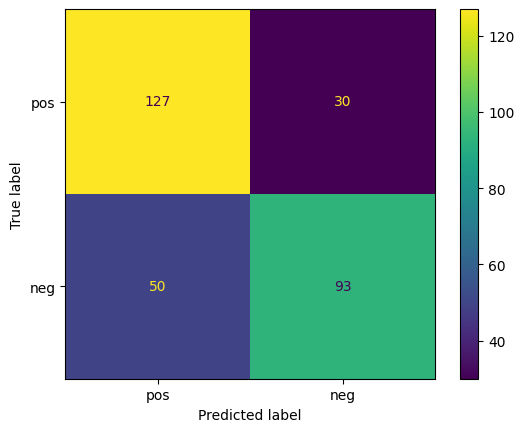

Clf: BernoulliNB()
Train Accuracy Score : 95% 
Test Accuracy Score  : 72% 
              precision    recall  f1-score   support

         pos       0.76      0.72      0.74       167
         neg       0.67      0.72      0.70       133

    accuracy                           0.72       300
   macro avg       0.72      0.72      0.72       300
weighted avg       0.72      0.72      0.72       300



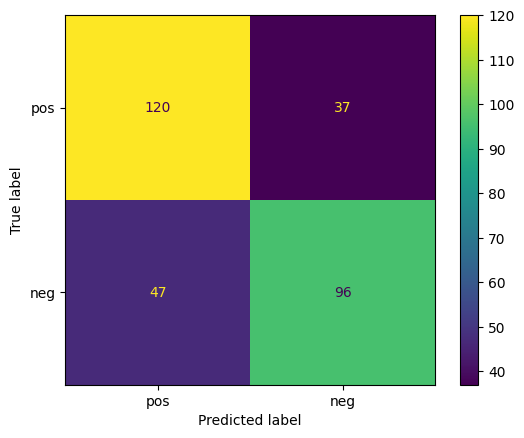

Clf: LogisticRegressionCV(cv=5, random_state=24)
Train Accuracy Score : 98% 
Test Accuracy Score  : 69% 
              precision    recall  f1-score   support

         pos       0.71      0.71      0.71       157
         neg       0.68      0.68      0.68       143

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300



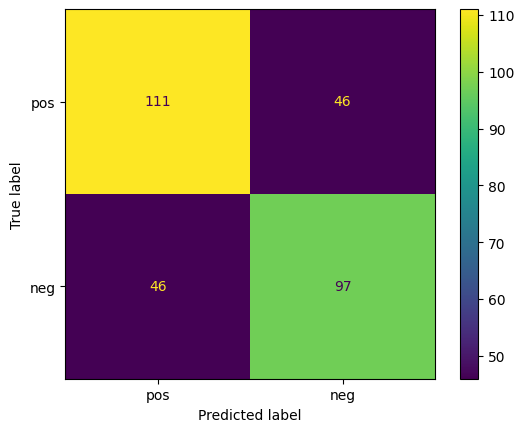

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn import svm

clfs = [
    MultinomialNB(),
    BernoulliNB(),
    LogisticRegressionCV(cv=5, random_state=24),
]

for clf in clfs:
    model_result(clf, X_train, Y_train, X_test, Y_test)

Clf: MultinomialNB()
Train Accuracy Score : 96% 
Test Accuracy Score  : 73% 
              precision    recall  f1-score   support

         pos       0.81      0.72      0.76       177
         neg       0.65      0.76      0.70       123

    accuracy                           0.73       300
   macro avg       0.73      0.74      0.73       300
weighted avg       0.74      0.73      0.74       300



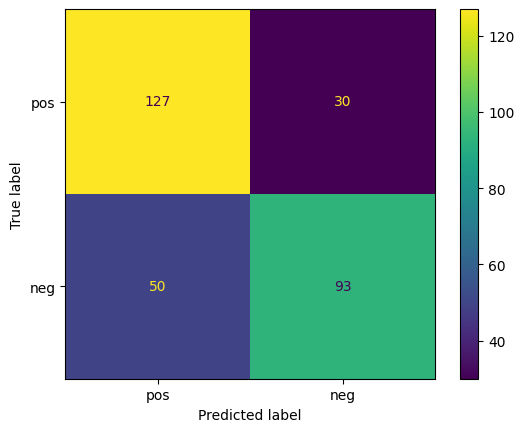

In [35]:
MNB = model_result(MultinomialNB(), X_train, Y_train, X_test, Y_test)

In [37]:
MNB.predict(["hello world"])[0]

4

In [45]:
input_text = input()
clean_text = preProcessing(input_text)
token = tokenize(clean_text)
lemat = Lemmatizer(token)

print(input_text)
if MNB.predict(lemat)[0] == 4:
    print("Positive")
else:
    print("Negative")

Happy birthday ðŸŽ‰
Positive
